In [ ]:
"""
This code gets fluxes (absorbed or unabsorbed) 
from the icm model parameters

1. get the final model para in log file
2. input into softwares
3. get flux and log it
4. collect all fluxes and save to 

"""

# 1 get model para

## 1.1 xspec

In [ ]:
from glob import glob
import os
import numpy as np
import re
from tqdm import tqdm

In [ ]:
## xspec icm models


datpath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata/XGAP'
dirs = glob(f'{datpath}/SDSSTG*')
mdl = '1T'


for dir in tqdm(dirs):
    logfile = f'{dir}/fit_231115/logs/annu_R500-01_{mdl}_allpar.log'
    print(dir)
    with open(f'get_fluxes_xspec_{mdl}.xcm') as f:
        content = f.read()
    if glob(logfile):
        with open(logfile) as f:
            output = f.read()

            # extract tbabs
            tbab_pat = re.compile(r'TBabs\s+\w+\s+.*\s*(\d+\.\d+E*-*\d*)\s+frozen')
            it = tbab_pat.finditer(output)
            tbab = next(it).group(1)
            
            # extract reds
            reds_pat = re.compile(r'apec\s+Redshift\s+.*\s*(\d+\.\d+E*-*\d*)\s+frozen')
            it = reds_pat.finditer(output)
            reds = next(it).group(1)

            # extract paras of IGrM model in table
            apec_pat = re.compile(r'apec\s+\w+\s+\w*\s*(\d+\.\d+E*-*\d*)\s+\+/-\s+(\S+)')
            it = apec_pat.findall(output)
            content = content.replace('ABS', tbab)
            content = content.replace('TEMP', it[0][0])
            content = content.replace('Abun', it[1][0])
            content = content.replace('REDS', reds)
            content = content.replace('NORM', it[2][0])
            content = content.replace('MDL', mdl)
            content = content.replace('PATH', f'{dir}/fit_231115')
        with open(f'{dir}/fit_231115/bins/get_fluxes_xspec_{mdl}.xcm', 'w') as newf:
            newf.write(content)

        os.system(f'cd {dir}/fit_231115')
        os.system(f'''
xspec<<EOT
@{dir}/fit_231115/bins/get_fluxes_xspec_{mdl}.xcm
exit
EOT
    ''')

    

## 1.2 spex

In [ ]:
# read from table
import pandas as pd

datpath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata/XGAP'
basics = pd.read_csv(f'{datpath}/../dats/basics_allsources.csv')
spex_1T = pd.read_csv(f'{datpath}/../dats/R500-01_1T_spex.csv')

dirs = glob(f'{datpath}/SDSSTG*')
mdl = '1T'


for dir in tqdm(dirs):
    id = dir.split('/')[-1]
    logfile = f'{dir}/fit_spex_231115/logs/annu-R500-01-{mdl}_error.out'
    with open(f'get_fluxes_spex_{mdl}.com') as f:
        content = f.read()
    if glob(logfile):
        fil_sp = spex_1T['ID'] == id
        fil_ba = basics['ID'] == id
        norm = spex_1T['n-value'][fil_sp]
        temp = spex_1T['T-value'][fil_sp]
        abun = spex_1T['Z-value'][fil_sp]
        reds = basics['z'][fil_ba]
        nh = float(basics['nH(1e20cm-2)'][fil_ba]) * 1e-24
        content = content.replace('ABS', str(nh))
        content = content.replace('TEMP', str(float(temp)))
        content = content.replace('Abun', str(float(abun)))
        content = content.replace('REDS', str(float(reds)))
        content = content.replace('NORM', str(float(norm)))
        content = content.replace('MDL', mdl)
        content = content.replace('PATH', f'{dir}/fit_spex_231115')
 
        with open(f'{dir}/fit_spex_231115/bins/get_fluxes_spex_{mdl}.com', 'w') as newf:
            newf.write(content)
        os.system(f'''
source /Users/eusracenorth/miniconda3/envs/spex/opt/spex/spex-activate.sh
spex<<EOT
log exe {dir}/fit_spex_231115/bins/get_fluxes_spex_{mdl}
quit
EOT
        ''')

# 2 tidy the log files

In [6]:
from unyt import W,s,ergs,cm,m
import pandas as pd
types = ['unabsflux', 'absflux']

datpath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata/XGAP'
dirs = glob(f'{datpath}/SDSSTG*')
mdl = '1T'

# initialize dict
output_dict = {}
output_dict['ID'] = []
for type in types:
    output_dict[f'spex_{type}'] = np.zeros(len(dirs))
    output_dict[f'xspec_{type}'] = np.zeros(len(dirs))

for i, dir in enumerate(dirs):
    id = dir.split('/')[-1]
    output_dict[f'ID'].append(id)

    for type in types:
        # extract energy flux from spex
        logfile = f'{dir}/fit_spex_231115/logs/get_fluxes_spex_{type}_{mdl}.out'
        if glob(logfile):
            with open(logfile) as f:
                output = f.read()
                print(output)
                pat = re.compile(r'\s+1\s+3\s+cie\s+\d*\.\d*E*.\d*\s+(\d*\.\d+E-\d+)')
                it = pat.findall(output)
                flux = (float(it[0]) * W/m**2).to(ergs/s/cm**2) 
                output_dict[f'spex_{type}'][i] = f'{flux.value:.4e}'

        # extract energy flux from xspec
        logfile = f'{dir}/fit_231115/logs/get_fluxes_xspec_{type}_{mdl}.log'
        if glob(logfile):
            with open(logfile) as f:
                output = f.read()
                pat = re.compile(r'\((\d+\.\d+e-\d+)\s+ergs')
                it = pat.findall(output)
                output_dict[f'xspec_{type}'][i] = float(it[0])

pd.options.display.float_format = '{:,.4e}'.format
df = pd.DataFrame(output_dict)
df.to_csv(f'{datpath}/../dats/get_fluxes_05-2.csv')



--------------------------------------------------------------------------------------------------
sect comp mod  acro parameter with unit     value      status    minimum   maximum lsec lcom lpar



   1    3 cie  norm ne nX V (1E64/m**3)   3263240.     thawn     0.0      1.00E+20
   1    3 cie  t    Temperature (keV)    0.8928100     thawn    1.00E-05  1.00E+03



--------------------------------------------------------------------------------
 Fluxes and restframe luminosities between  0.50000     and    2.0000     keV

 sect comp mod   photon flux   energy flux nr of photons    luminosity
              (phot/m**2/s)      (W/m**2)   (photons/s)           (W)
    1    3 cie   0.128018      1.767036E-17  7.362345E+49  1.023985E+34

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------
sect comp mod  acro parameter with unit     value      status    minimum   

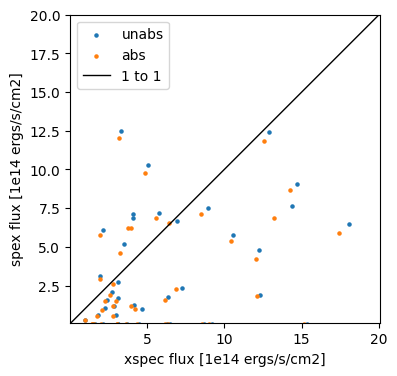

0    3.6189e+00
1           inf
2    4.9040e-01
3    6.3708e-01
4    1.1394e+00
5           inf
6           NaN
7    2.6804e-01
8           inf
9           NaN
10          inf
11          NaN
12   2.5517e+00
13   9.3893e-01
14   1.3004e+00
15   5.9645e-01
16   1.1936e+00
17          inf
18   6.7717e-01
19          inf
20   5.8094e-01
21   1.8671e+00
22   3.4894e+00
23   1.8779e+00
24          inf
25          inf
26   1.5473e+00
27          inf
28   3.1073e+00
29   6.4994e+00
30          inf
31          inf
32   2.7766e+00
33   1.6218e+00
34   3.2025e+00
35          NaN
36   2.3809e+00
37   1.0339e+00
38   8.0580e-01
39   5.1286e+00
40          inf
41   2.1739e+00
42   3.5434e-01
43   4.7067e+00
44   1.0383e+00
45   1.8242e+00
46   3.3654e+00
47   4.6675e+02
dtype: float64
SDSSTG11844


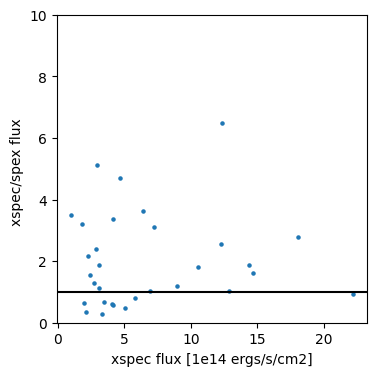

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

datpath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata/XGAP'

fig, ax = plt.subplots(figsize = (4,4))
df = pd.read_csv(f'{datpath}/../dats/get_fluxes_05-2.csv')
plt.scatter(df['xspec_unabsflux'] * 1e14, df['spex_unabsflux'] * 1e14, label = 'unabs', s = 5)
plt.scatter(df['xspec_absflux'] * 1e14, df['spex_absflux'] * 1e14, label = 'abs', s = 5)
plt.plot(np.arange(1000), np.arange(1000), label = '1 to 1', c = 'k', linewidth = 1)
plt.xlabel('xspec flux [1e14 ergs/s/cm2]')
plt.ylabel('spex flux [1e14 ergs/s/cm2]')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.axis('equal')
plt.xlim(0.1, 20)
plt.ylim(0.1, 20)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize = (4,4))
plt.axhline(1, color = 'k')
plt.scatter(df['xspec_unabsflux']* 1e14, df['xspec_unabsflux'] / df['spex_unabsflux'], label = 'unabs', s = 5)
plt.ylim(0,10)
plt.xlabel('xspec flux [1e14 ergs/s/cm2]')
plt.ylabel('xspec/spex flux ')
print(abs(df['xspec_unabsflux'] / df['spex_unabsflux']))
print(df['ID'][29])